<a href="https://colab.research.google.com/github/sungsy/ComputerVision_CatAndDog/blob/master/cat_dog_team1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![just that you know, we had a hard time](https://img-9gag-fun.9cache.com/photo/azmrnwq_700bwp.webp)

#import

In [ ]:
#import libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
from keras.preprocessing.image import load_img

#more libraries
import numpy as np
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

import sys
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler, EarlyStopping

# g-drive mount to colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#global variables

In [ ]:
#global variables, even if they are not global
input_shape = (200, 200, 3)
size = (200, 200)

# organize dataset

In [ ]:
#training data loading
train_dir = '/content/drive/My Drive/data/train/'

In [ ]:
#data prep
filenames = os.listdir(train_dir)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [ ]:
df.tail()

,filename,category
20563,dog.10650.jpg,1
20564,dog.10636.jpg,1
20565,dog.10647.jpg,1
20566,dog.10612.jpg,1
20567,dog.10619.jpg,1


In [ ]:
df.head()

In [ ]:
df.info

<bound method DataFrame.info of             filename  category
0       cat.8949.jpg         0
1       cat.8951.jpg         0
2       cat.8918.jpg         0
3       cat.8929.jpg         0
4       cat.8925.jpg         0
...              ...       ...
20563  dog.10650.jpg         1
20564  dog.10636.jpg         1
20565  dog.10647.jpg         1
20566  dog.10612.jpg         1
20567  dog.10619.jpg         1

[20568 rows x 2 columns]>

In [ ]:
# organize dataset into a useful structure
# credits to @Marina
# see https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/

from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
# create directories
dataset_home = '/content/drive/My Drive/dataset_dogs_vs_cats/'
subdirs = ['train/', 'val/']
for subdir in subdirs:
	# create label subdirectories
	labeldirs = ['dogs/', 'cats/']
	for labldir in labeldirs:
		newdir = dataset_home + subdir + labldir
		makedirs(newdir, exist_ok=True)
# seed random number generator
seed(1)
# define ratio of pictures to use for validation
val_ratio = 0.2
# copy training dataset images into subdirectories
src_directory = '/content/drive/My Drive/data/train/'
for file in listdir(src_directory):
	src = src_directory + '/' + file
	dst_dir = 'train/'
	if random() < val_ratio:
		dst_dir = 'val/'
	if file.startswith('cat'):
		dst = dataset_home + dst_dir + 'cats/'  + file
		copyfile(src, dst)
	elif file.startswith('dog'):
		dst = dataset_home + dst_dir + 'dogs/'  + file
		copyfile(src, dst)

# build model with InceptionResnetV2 feature extraction

How does feature extraction in transfer learning work
![feature extraction](https://miro.medium.com/max/1400/1*qfQ3hmHLwApXZBN-A85r8g.png)

![>>Inception<<](https://miro.medium.com/max/512/1*cwR_ezx0jliDvVUV6yno5g.jpeg)

In [ ]:
# feature extraction

from keras.applications import inception_resnet_v2
from keras.models import Model
import keras

incep = inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = incep.layers[-1].output
output = keras.layers.Flatten()(output)
incep_model = Model(incep.input, output)

incep_model.trainable = False
for layer in incep_model.layers:
    layer.trainable = False
    
import pandas as pd
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in incep_model.layers]
pd.DataFrame(layers[:-1], columns=['Layer Type', 'Layer Name', 'Layer Trainable'])   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7ff43896b240>,input_2,False
1,<keras.layers.convolutional.Conv2D object at 0x7ff4384146a0>,conv2d_204,False
2,<keras.layers.normalization.BatchNormalization object at 0x7ff43896f6a0>,batch_normalization_204,False
3,<keras.layers.core.Activation object at 0x7ff4383b9908>,activation_204,False
4,<keras.layers.convolutional.Conv2D object at 0x7ff4389664e0>,conv2d_205,False
...,...,...,...
775,<keras.layers.convolutional.Conv2D object at 0x7ff42a2bbeb8>,block8_10_conv,False
776,<keras.layers.core.Lambda object at 0x7ff42a251390>,block8_10,False
777,<keras.layers.convolutional.Conv2D object at 0x7ff42a251cc0>,conv_7b,False
778,<keras.layers.normalization.BatchNormalization object at 0x7ff42a26aef0>,conv_7b_bn,False


deciding which layer to unfreeze regarding the model structure to: https://arxiv.org/pdf/1602.07261.pdf


In [ ]:
# set trainable and not trainable layers

incep_model.trainable = True

set_trainable = False
for layer in incep_model.layers:
    if layer.name in ['conv_7b']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
print("Trainable layers:", incep_model.trainable_weights)

Trainable layers: [<tf.Variable 'conv_7b_1/kernel:0' shape=(1, 1, 2080, 1536) dtype=float32, numpy=
array([[[[ 0.01532602, -0.0052208 , -0.01629939, ..., -0.00750355,
          -0.02308533, -0.00625716],
         [ 0.00915081,  0.01679643, -0.01264298, ..., -0.00153045,
           0.00426828, -0.01116477],
         [-0.00938526,  0.01000807, -0.01302499, ...,  0.00135632,
           0.00878095, -0.01120999],
         ...,
         [ 0.01008214, -0.00962544,  0.00948761, ...,  0.00524579,
          -0.01899688,  0.00594557],
         [-0.00386446,  0.00974133, -0.03400516, ..., -0.00767208,
          -0.02028511, -0.01507504],
         [-0.00417665,  0.02147835,  0.01094093, ...,  0.02344603,
          -0.00350178, -0.00570382]]]], dtype=float32)>, <tf.Variable 'conv_7b_bn_1/beta:0' shape=(1536,) dtype=float32, numpy=
array([-0.044431  , -0.02422891, -0.03033594, ..., -0.0768236 ,
       -0.06014798, -0.07666148], dtype=float32)>]


In [ ]:
# show trainable and frozen layers

layers = [(layer, layer.name, layer.trainable) for layer in incep_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7ff43896b240>,input_2,False
1,<keras.layers.convolutional.Conv2D object at 0x7ff4384146a0>,conv2d_204,False
2,<keras.layers.normalization.BatchNormalization object at 0x7ff43896f6a0>,batch_normalization_204,False
3,<keras.layers.core.Activation object at 0x7ff4383b9908>,activation_204,False
4,<keras.layers.convolutional.Conv2D object at 0x7ff4389664e0>,conv2d_205,False
...,...,...,...
776,<keras.layers.core.Lambda object at 0x7ff42a251390>,block8_10,False
777,<keras.layers.convolutional.Conv2D object at 0x7ff42a251cc0>,conv_7b,True
778,<keras.layers.normalization.BatchNormalization object at 0x7ff42a26aef0>,conv_7b_bn,True
779,<keras.layers.core.Activation object at 0x7ff42a26af98>,conv_7b_ac,True


++Baustelle++ für mehr Augmentation

In [ ]:
#heavy augmentation with imgaug | follow: https://imgaug.readthedocs.io/en/latest/source/examples_basics.html

import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa


ia.seed(1)

# Example batch of images.
# The array has shape (20567, 150, 150, 3) and dtype uint8.
images = np.array(
    [ia.quokka(size=(200, 200)) for _ in range(20567)],
    dtype=np.uint8
)

seq = iaa.Sequential([
    iaa.Flipud(0.2), # vertically flip 20% of all images
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(
        loc=0, 
        scale=(0.0, 0.05*255), 
        per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-45, 45),
        shear=(-16, 16),
        order=[0, 1],
        cval=(0, 255),
        mode=ia.ALL
    )
    
], random_order=True) # apply augmenters in random order

In [ ]:
train_datagen_heavy_aug = ImageDataGenerator(
    rescale=1.0/255, 
    preprocessing_function=seq.augment_image
)

In [ ]:
# data augmentation
# not used since model performs even better with "heavy augmentation"

train_datagen = ImageDataGenerator(
    rescale=1.0/255, 
    rotation_range=40, 
    zoom_range =0.20,
		shear_range=0.2,
		brightness_range=(0.1, 0.5),
    width_shift_range=0.2, 
    height_shift_range=0.2,
		horizontal_flip=True,
		fill_mode='nearest'
)


val_datagen = ImageDataGenerator(rescale=1.0/255)

train_it = train_datagen_heavy_aug.flow_from_directory('/content/drive/My Drive/dataset_dogs_vs_cats/train/', class_mode='binary', batch_size=64, target_size= size)
val_it = val_datagen.flow_from_directory('/content/drive/My Drive/dataset_dogs_vs_cats/val/', class_mode='binary', batch_size=64, target_size= size)

Found 16390 images belonging to 2 classes.
Found 4178 images belonging to 2 classes.


In [ ]:
# load the model

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

model = Sequential()
model.add(incep_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3)) 
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.6)) 
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 24576)             54336736  
_________________________________________________________________
dense_15 (Dense)             (None, 512)               12583424  
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 513       
Total params: 67,183,329
Trainable params: 16,043,009
Non-trainable params: 51,140,320
_________________________________

In [ ]:
# callbacks
# not used
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
earlystopping = EarlyStopping(monitor='val_loss', patience=5)

Epoch 1/8


/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 249 could not be retrieved. It could be because a worker has died.
  UserWarning)


100/100 [==============================] - 3748s 37s/step - loss: 0.5103 - accuracy: 0.7258 - val_loss: 0.1736 - val_accuracy: 0.9834
Epoch 2/8
100/100 [==============================] - 3472s 35s/step - loss: 0.3726 - accuracy: 0.8239 - val_loss: 0.4742 - val_accuracy: 0.9750
Epoch 3/8
100/100 [==============================] - 2580s 26s/step - loss: 0.3432 - accuracy: 0.8403 - val_loss: 0.0780 - val_accuracy: 0.9854
Epoch 4/8
100/100 [==============================] - 1740s 17s/step - loss: 0.3111 - accuracy: 0.8564 - val_loss: 0.3405 - val_accuracy: 0.9835
Epoch 5/8
100/100 [==============================] - 1641s 16s/step - loss: 0.2959 - accuracy: 0.8700 - val_loss: 0.2953 - val_accuracy: 0.9850
Epoch 6/8
100/100 [==============================] - 1691s 17s/step - loss: 0.2752 - accuracy: 0.8765 - val_loss: 0.1314 - val_accuracy: 0.9851
Epoch 7/8
100/100 [==============================] - 1792s 18s/step - loss: 0.2806 - accuracy: 0.8769 - val_loss: 0.3526 - val_accuracy: 0.9829
Ep

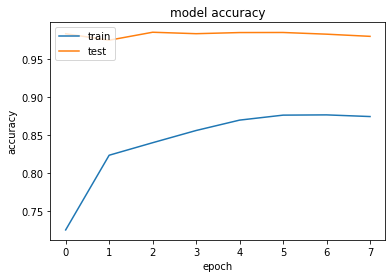

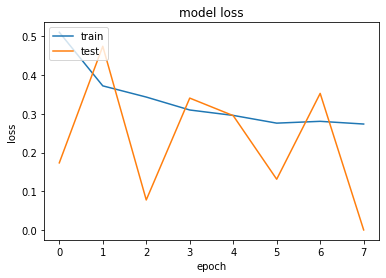

In [ ]:
# run model

history = model.fit_generator(train_it, 
                              steps_per_epoch=100, #100
                              epochs=8, #20, but testwise we had best acc at 7-8 epochs
                              validation_data=val_it, 
                              validation_steps=50,
                              #callbacks=[annealer, earlystopping],  
                              verbose=1
                              )

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# save model weights | https://stackoverflow.com/questions/48924165/google-colaboratory-weight-download-export-saved-models

model.save('InceptionResNet_featureextraction.h5')

![memes for president](https://cathumor.net/wp-content/uploads/2015/08/cat-humor-found-it-another-home-for-dog.jpg)

# build model with VGG16 for feature extraction | performs not as good as the InceptionResNet

In [ ]:
# feature extraction

from keras.applications import vgg16
from keras.models import Model
import keras

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False
    
import pandas as pd
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])   

In [ ]:
# set trainable and not trainable layers

vgg_model.trainable = True

set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
print("Trainable layers:", vgg_model.trainable_weights)

![alt text](https://miro.medium.com/max/1400/1*W91k18rRAZfJnsM8bhUDXA.png)

In [ ]:
# show trainable and frozen layers

layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

🚧--!Baustelle!--🚧 | Für eine bessere Augmentation

In [ ]:
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa


ia.seed(1)

# Example batch of images.
# The array has shape (20567, 150, 150, 3) and dtype uint8.
images = np.array(
    [ia.quokka(size=(150, 150)) for _ in range(20567)],
    dtype=np.uint8
)

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True) # apply augmenters in random order

images_aug = seq(images=images)

In [ ]:
# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1.0/255, 
    rotation_range=40, 
    zoom_range =0.20,
		shear_range=0.2,
		brightness_range=(0.1, 0.5),
    width_shift_range=0.2, 
    height_shift_range=0.2,
		horizontal_flip=True,
		fill_mode='nearest'
)
 
val_datagen = ImageDataGenerator(rescale=1./255)

train_it = train_datagen.flow_from_directory('/content/drive/My Drive/dataset_dogs_vs_cats/train/', class_mode='binary', batch_size=64, target_size= size)
val_it = val_datagen.flow_from_directory('/content/drive/My Drive/dataset_dogs_vs_cats/val/', class_mode='binary', batch_size=64, target_size= size)

Found 16390 images belonging to 2 classes.
Found 4178 images belonging to 2 classes.


In [ ]:
# load the model

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])

model.summary()

In [ ]:
# callbacks
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
earlystopping = EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
# run model

history = model.fit_generator(train_it, 
                              steps_per_epoch=100, 
                              epochs=20,
                              validation_data=val_it, 
                              validation_steps=50,
                              callbacks=[annealer, earlystopping], 
                              verbose=1
                              )  

Epoch 1/100


/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 106 could not be retrieved. It could be because a worker has died.
  UserWarning)


100/100 [==============================] - 5170s 52s/step - loss: 0.6536 - accuracy: 0.6173 - val_loss: 0.3921 - val_accuracy: 0.8644
Epoch 2/100
100/100 [==============================] - 4123s 41s/step - loss: 0.5291 - accuracy: 0.7325 - val_loss: 0.2993 - val_accuracy: 0.8672
Epoch 3/100
100/100 [==============================] - 3649s 36s/step - loss: 0.4505 - accuracy: 0.7878 - val_loss: 0.1976 - val_accuracy: 0.9166
Epoch 4/100
100/100 [==============================] - 3475s 35s/step - loss: 0.3996 - accuracy: 0.8186 - val_loss: 0.2015 - val_accuracy: 0.9242
Epoch 5/100
100/100 [==============================] - 3472s 35s/step - loss: 0.3770 - accuracy: 0.8283 - val_loss: 0.1587 - val_accuracy: 0.9334
Epoch 6/100
100/100 [==============================] - 3418s 34s/step - loss: 0.3208 - accuracy: 0.8560 - val_loss: 0.2056 - val_accuracy: 0.9277
Epoch 7/100
100/100 [==============================] - 3468s 35s/step - loss: 0.3124 - accuracy: 0.8580 - val_loss: 0.0761 - val_accurac

In [ ]:
# save model weights

model.save('vgg_featureextraction.h5')

# prepare test data

In [ ]:
#preparing test data

test_filenames = os.listdir('/content/drive/My Drive/data/test')
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    '/content/drive/My Drive/data/test/', 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=size,
    batch_size=64,
    shuffle=False
)

Found 5000 validated image filenames.


In [ ]:
#predict
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/64), verbose=1)

79/79 [==============================] - 883s 11s/step


![Truck Fonald Dump](https://miro.medium.com/max/690/1*_nlD_29zMs5Ls-1uy6Mm1g.png)

In [ ]:
print(predict)
print(len(predict))

[[3.8475239e-18]
 [1.0000000e+00]
 [5.5580311e-16]
 ...
 [7.6547085e-10]
 [1.0000000e+00]
 [1.0000000e+00]]
5000


In [ ]:
#taking cateogory with highest probability
threshold = 0.5
test_df['category'] = np.where(predict > threshold, 1,0)

In [ ]:
print(test_df)

      filename  category
0     4000.jpg  0       
1     4001.jpg  1       
2     4002.jpg  0       
3     4003.jpg  1       
4     4004.jpg  1       
...        ... ..       
4995  995.jpg   0       
4996  996.jpg   0       
4997  997.jpg   0       
4998  998.jpg   1       
4999  999.jpg   1       

[5000 rows x 2 columns]


![Neural Networks regieren die Welt](https://images.ctfassets.net/be04ylp8y0qc/1AYDDqzqoLNU7GyvMOLlTL/146ab0e8b96a25c1b3538a2929dae646/meme_6cce0f3bba63820b84f52ce05a822975_800.png?fm=jpg)

In [ ]:
#label pictures
test_df['category'] = test_df['category'].replace({ 1 : "dog", 0 : "cat" })

In [ ]:
print(test_df)

      filename category
0     4000.jpg  cat    
1     4001.jpg  dog    
2     4002.jpg  cat    
3     4003.jpg  dog    
4     4004.jpg  dog    
...        ...  ...    
4995  995.jpg   cat    
4996  996.jpg   cat    
4997  997.jpg   cat    
4998  998.jpg   dog    
4999  999.jpg   dog    

[5000 rows x 2 columns]


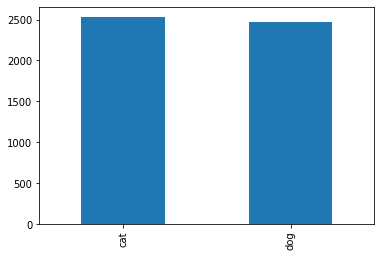

In [ ]:
#show result
test_df['category'].value_counts().plot.bar()

In [ ]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('predictions_team1.csv', index=False)

In [ ]:
#download submission

from google.colab import files
files.download('predictions_team1.csv')

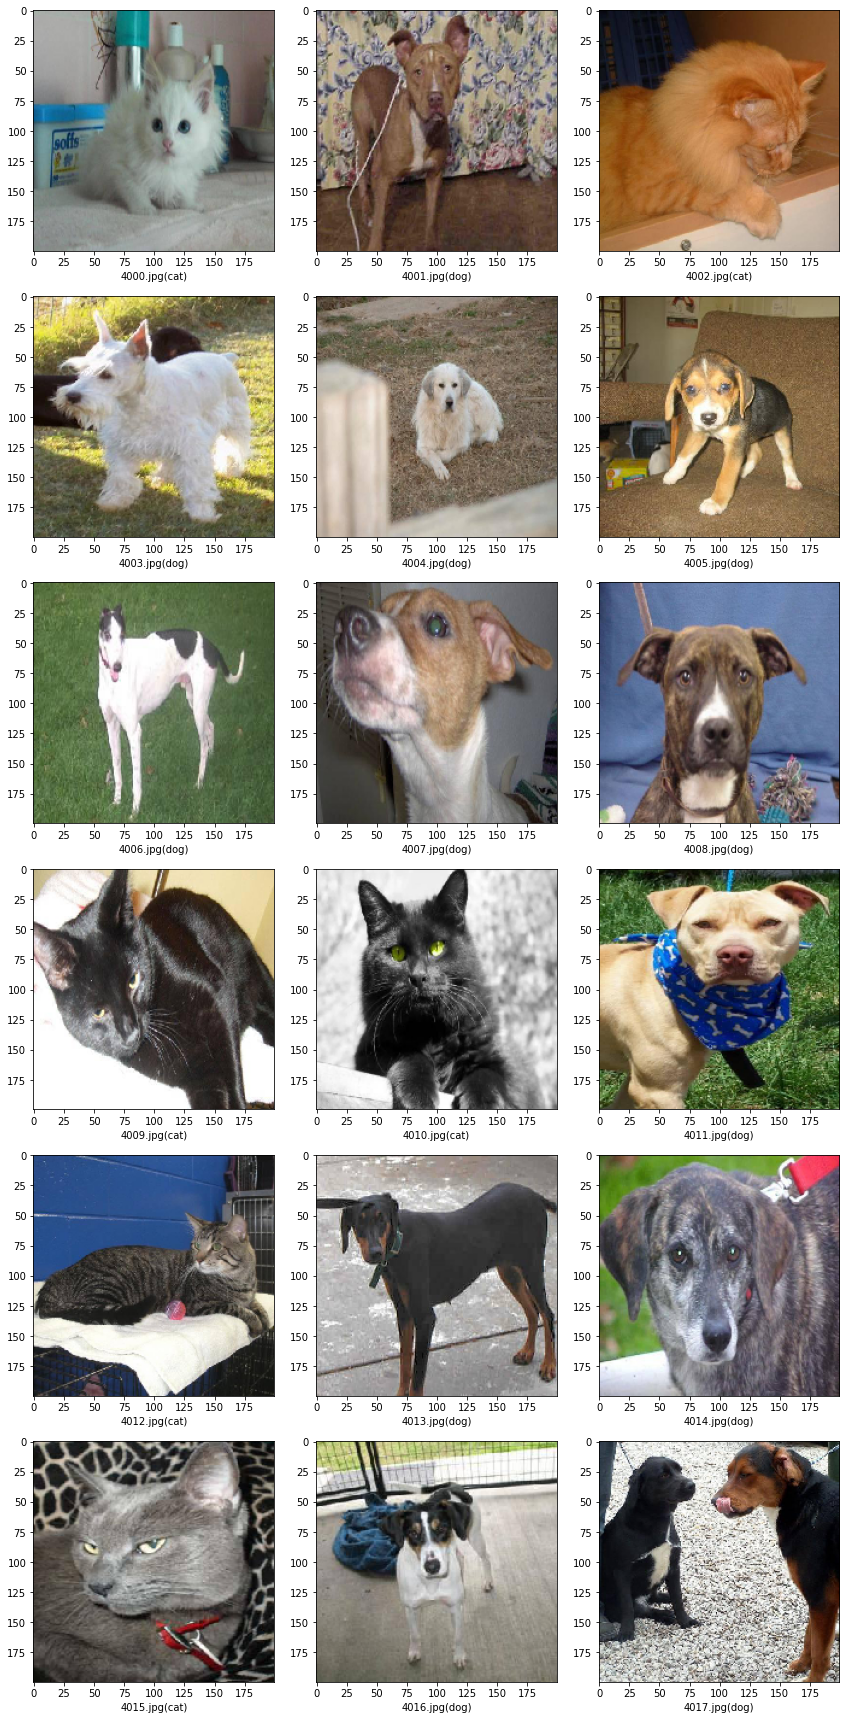

In [ ]:
#in images
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img('/content/drive/My Drive/data/test/'+filename, target_size=size)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

![alt text](https://i.chzbgr.com/full/8402865664/h3773ADD2/sorry-for-the-long-post)